# **시계열 데이터 이상한데?**

오늘은 시계열 데이터에서 이상한 부분을 찾아내는 이상치 탐색(Anomaly Detection)에 대해 배워본다.

    만약 여러분이 수백대의 생산설비가 24시간 무중단 운영중인 대규모의 제조시설  
    운영을 맡고있는 책임자라고 생각해 봅시다.

    그 수백대의 설비는 서로 긴밀하게 맞물려 운영되는데, 자칫 그 중 한 설비에 
    이상이 생기기라도하면 공장 전체가 올스톱되어 어마어마한 손실이 발생하게 될 
    것입니다. 

    문제는, 설비가 고장이나기 직전까지 겉으로 봐서는 아무런 문제가 드러나지 
    않기 때문에 도저히 문제 발생을 미리 예측할 수 없다는 점입니다.

    할수 있는 거라곤 멀쩡하게 잘 쓰고 있는 설비도 '그나마 안심하고 쓸수 있는' 
    안심내구연한이 지나면 무조건 새것으로 교체하거나, 

    아니면 설비 센서 앞에 관리자를 24시간 교대근무시키면서 만일의 사태에 빠르게 
    대응하도록 하는 것뿐이겠지요.


이럴때 정확한 Anomaly Detection 모델을 확보할 수 있다면 큰 도움이 될 것이다.
설비에 부착된 센서의 시계열 데이터를 면밀히 분석해, 이상발생 얼마 전에 나타나는 이상 징후를 빠르게 포착해서 미리 대리할 수 있게 하면, 만일에 발생할수 있는 천문학적 손실을 예방할 수 있는 요긴한 솔루션이 될거다.

곡 시계열이 아니더라도 이미지에 대한 Anomaly Detection 분석을 통해 불량품을 찾아내거나 공항/ 항만에서 반입 금지 품목을 수색하는 등 다양한 용도의 Anomaly Dectection 기법을 생각할 수 있다.

오늘은 우리에게 주어진 데이터를 분석해서 보다 신뢰할 수 있는 데이터로 가공해 가는 전처리 과정의 일부로 접근해 볼까 한다.

"Garbage in,  Garbage out" 이라는 말이 있다.
분석 데이터가 얼마나 중요한지 알려주는 격언이다.

'이상한 데이터 = 이상치(Anomalies)' 는 어떻게 정의할 수 있을까?
"Garbage"소리를 안 들으려면 이상치들은 어떻게 처리해야 할까? 

이번 노드에서는 시계열 데이터 속에서 이상치의 의미를 파악하고, 똑똑하게 찾아내는 방법을 알아보고 이상처리하는 방법까지 연결해 볼 거다.


**학습 목표**

- 시계열 데이터의 이상치의 개념을 이해한다.
- 다양한 방법으로 이상치를 탐색해본다.
- 발견한 이상치를 처리하는 방법을 알아본다.

**목차**
1. 들어가며
2. 이상한 데이터는 어떻게 생겨났을까요?
3. 신입 데이터 분석가 되어보기: 시계열 데이터 준비
4. Outlier/ Novelties 구분하기
5. 확률분포로 이상치 찾아내기
6. 클러스터링으로 이상치 찾아내기
7. LSTM auto encoder로 이상치 찾아내기




#**2. 이상한 데이터는 어떻게 생겨났을까?**

데이터 속에는 유독 혼자서 톡톡 튀는 값들이 있다.

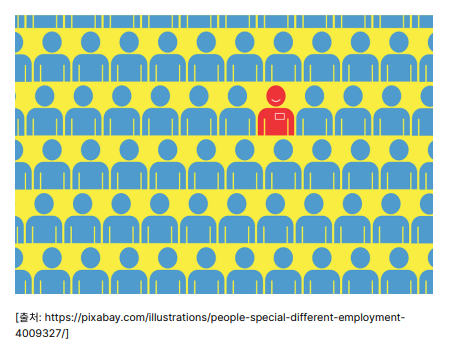

우리는 이 데이터에서 두 가지 방법으로 해석할 수 있다.

1. "세상에는 파란 사람 말고 빨간 사람도 있구나!"
2. "어쩌다가 데이터에 빨간 사람이 들어왔지?"

모델은 데이터를 통해서 외부환경을 학습해요.
모든 사람의 색이 파란색인 데이터만 입력받은 모델은 빨간 사람이나 초록 사람은 예측 할수 없다.

이때, 입력데이터에 나타난 빨간 사람은 모델이 학습할 외부환경을 추가해서 더 좋은 모델이 되게끔 해준다.

그런데 만약 빨간 사람은 존재하지 않고 단순한 데이터 오류라면, 모델은 빨간 사람 데이터를 학습하지 않는편이 더 좋을것이다.

한번이라도 빨간 사람을 학습하면, 특정 경우에는 사람의 색이 빨간색이라고 예측할 수 있고, 그건 늘 틀린답 일테니까.

우리는 이상한 데이터를 보고 판단해야 한다.
"이 데이터는 어떻게 생성된 건가?"



**데이터를 무조건적으로 믿으면 안 되는 이유**

데이터를 100% 믿는 건 굉장히 위험한 행동이다.

우리가 다루는 모든 데이터는 생성/ 측정되고, 수집/ 전달돼서 우리의 컴퓨터로 들어왔다.

이런 데이터 파이프라인 속에서 데이터가 오염될 가능성은 결코 0%가 아니다.

각 단계별 어떤 위험이 있는지 알아보자.

**생성/ 측정 단계**

- 관측자의 실수(휴먼에러)
- 측정 장비의 오류

기상 데이터의 경우, 자동화 측정 장비가 도입되기 전에는 관측관이 직접 수은온도계를 보고, 하늘 상태를 눈으로 봐서 기록했다.

온도계가 고장 났거나, 노후화 됐거나, 관측관의 실수가 있었다면 이상한 데이터가 입력된다.

자동화된 IoT 센서도 문제가 없는 건 아니다. 센서는 종종 오작동을 하거나 고장 나기도 한다.

각종 산업현장에서는 주기적으로 센서 정확도를 점검하나, 그 사이에 발생하면 끔찍한 사고로 연결 되기도 한다.

- 보잉 "추락사고 센서 오작동 때문"

**수집/ 전달 단계**

- 데이터 수집 프로그램의 오류(버그)
- 데이터 관리자의 실수(휴먼에러)
- 데이터 전달 프로그램의 오류(Open API)

급증한 데이터 생성량에 맞춰, 많은 데이터들이 자동 프로그램으로 수집되고 있다.

생성/측정은 정상적으로 이뤄 졌더라도, 수집 프로그램에 버그가 있다면 이상한 데이터가 저장되었을 거다.

**실무에서 가장 흔한 데이터 오염은 데이터 관리자에 의해 발생한다.**

직접 raw 데이터부터 DB까지 뜯어보며 해결할 수 있는 문제가 아니라면 해결하기 가장 까다로운 문제이다.

모든 위험을 벗어나도 Open API 설계에 오류가 있다면, 우리가 수집한 데이터에는 이상한 값이 들어있을 거다.(Open API는 null값을 0으로 반환하는 버그가 가장 흔하다.)

**이상한 데이터를 찾아내는 방법(Anomaly Detection)**

데이터 파이프라인 관리자들은 이런 오류를 막기 위해서 온갖 노력을 기울이고 있다.

그러니 우리는 이런 전제를 세울 수 있다.

"대부분의 데이터는 참이고, 이상한 데이터는 극히 일부일 것이다."

우리는 어떻게 해야 이상한 데이터를 찾아낼 수 있을까?

- 다시 측정한다.
- 같은 데이터의 다른 출처를 찾아서 비교한다(Supervised)
- 데이터 스스로의 특징을 활용해서 찾아낸다 (Unsupervised)

시계열 데이터의 특성상, 과거로 돌아가 다시 측정하는 방법은 불가능하다.

같은 데이터를 제동하는 다른 출처가 있다면 Supervised 방법을 쓸수 있다.

1. 각 데이터를 비교해서 다른 데이터를 찾는다. 서로 같은 데이터는 정상으로 분류한다.

2. 서로 다른 데이터중 '더 이상한' 데이터를 이상치로 분류

3. 라벨링 된 분류 결과로 이상치 탐색 모델을 학습한다.

대부분의 경우에, 다른 출처가 없어, Unsupervised 방법을 쓰게 될 것이다.

대부분의 데이터는 참 이라는 전제하에 이상한 데이터를 찾아내는 거다.

1. 데이터 스스로의 특징을 분석한다.

2. 특정 기준보다 '더 이상한' 데이터를 이상치로 분류한다.



그렇다면 다음 퀴즈를 풀어보며 생각을 정리해봐요
    
    Q1. 주가데이터는 네이버, 카카오, 야후 파이낸스 등 다양한 회사에서 제공하고  
    있어요. 만약에 네이버를 통해 수집한 주가 데이터가 의심된다면 어느 방법으로 
    이상한 데이터를 찾아낼 수 있을까요?

    다른회사에서 제공하는 같은 데이터와 비교해 보는 Supervised 방법을 사용 가능

    Q2. 여러분이 기상청에서 기온 데이터를 수집했는데, 뭔가 이상한걸 발견 
    했어요. 오늘 오후 1시, 2시, 3시의 서울 기온이 [24, 50, 22] 라고 나왔거든요. 
    어떻게 해야 할까요?

    다른 기상데이터 제공업체를 찾아서, 기상청 데이터와 비교해요. 찾을 수 없다면 
    기온의 분포에서 크게 벗어난 50도를 이상치로 분류해요.

#**3.신입 데이터 분석가가 되어보자**

데이터 분석 업무는 고상할 거라는 세간의 믿음과 달리, 현장에서는 많은 투쟁이 벌어지곤 한다.

지금부터 여러분은 신입 데이터 분석가가 되는 경험을 통해서 이론이 아니라 현장에서는 이상치 데이터를 어떻게 대처해 나가야 하는지 체험해볼 거에요.


**팀장님, "코스피 데이터는 다뤄본 적 있어요?**

여러분) 안녕하세요! 신입사원 ㅇㅇㅇ 입니다.

팀장) 응 잘왔어요. 뛰어난 인재라는 얘기를 많이 들었어요.

팀장) 방금 기획팀에서 코스피 데이터를 뽑아달라는 요청을 받았는데 몸풀기로 맡겨도 되겠죠? 오픈데이터를 수집해야할 거에요.

여러분)(답은 정해져 있다.) 네! 맡겨 주세요!

**Time Series 데이터 불러오기: KOSPI**

갓 취직한 여러분에게 주어진 첫 업무이니 잘 해내고 싶어요.

왠지 주가 데이터는 많은 돈이 걸려있으니 이상치가 없을거 같아요. 진짜 그럴까요?

우선 야후 파이낸스를 통해서 코스피 데이터를 수집하기로 해요.

request는 외부 서버에 데이터를 요청할 때 쓰는 라이브러리 입니다.



In [1]:
pip install requests

그리고 아래와 같이 작업 환경을 구성해 봅시다.

In [2]:
mkdir -p ~/aiffel/anomaly_detection/kospi

In [3]:
import requests
import os

#아래 url은 yahoo finance 서버에 우리나라 코스피 데이터를 요청하는 주소입니다.

url = "https://query1.finance.yahoo.com/v7/finance/download/%5EKS11?period1=867715200&period2=1597276800&interval=1d&events=history"

#데이터를 요청하고 그 결과를 response로 받습니다.
response = requests.get(url)

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/kospi.csv'

#response 의 컨텐츠를 csv로 저장합니다.
with open(csv_file, "w") as fp:
  fp.write(response.text)


우선은 야후에서 받아온 데이터를 'kospi.csv' 로 저장했어요

(주의) 하지만 방금 다운받은 kospi.csv 대신 아래 링크의 데이터셋을 대신 사용해 주세요! 아래 이후의 내용은 Yahoo finance에서 제공하는 데이터에 포함된 이상데이터(극단치와 특이치)를 추적하는 과정을 다루고 있습니다.

하지만 2021년 1월 현재, Yahoo finace의 데이터 내의 오류가 수정되어 아래에서 제시하는 학습내용이 재현되지 않는 문제가 있습니다.

그래서, 원활한 실습을 위해 이상데이터가 포함된 구버전 데이터셋을 사용해 주시기를 바랍니다.



In [9]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/kospi.csv

!mv kospi.csv ~/aiffel/anomaly_detection/kospi

--2021-05-26 12:38:18--  https://aiffelstaticprd.blob.core.windows.net/media/documents/kospi.csv
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440923 (431K) [text/csv]
Saving to: ‘kospi.csv’

kospi.csv           100%[===================>] 430.59K   511KB/s    in 0.8s    

2021-05-26 12:38:19 (511 KB/s) - ‘kospi.csv’ saved [440923/440923]



Pandas 라이브러리에서 제공하는 DataFrame 타입으로 데이터를 불러와서 값을 확인합니다.

In [10]:
#저장한 csv를 읽어옵니다.
import pandas as pd
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,744.979980,760.520020,744.669983,758.030029,758.030029,0.0
1,1997-07-02,763.390015,777.289978,763.390015,777.289978,777.289978,0.0


불러온 데이터셋은 일반적인 다변량 시계열 데이터의 형태를 띠고 있다.

딱 봐도 주가데이터임을 알수 있는 Open/High/Low/Close/Volumn등 컬럼명이 보인다.

'Date'는 시간데이터지만, CSV를 통해 불러와서 data type이 string일 거다.

이걸 Datetime 으로 캐스팅하고 결측치 유무를 확인한다.

우선 컬럼명이 의미하는 바가 뭔지 확인한다.

    Q3. 주식 데이터에서 Open, High, Low, Close, Adj Close, Volume은 각각 무슨 
    의미일까요?

    각각 시가, 고가, 저가, 종가, 보정종가, 거래량

In [12]:
#날짜 데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:, 'Date'] = pd.to_datetime(df.Date)


In [13]:
#데이터의 정합성을 확인합니다.
df.isna().sum()

Date           0
Open         150
High         150
Low          150
Close        150
Adj Close    150
Volume       150
dtype: int64

결측치가 있는 날짜가 150개나 되네요.

이대로 내버려 두면 모델에서 예상치 못한 오류가 발생할 수 있어요.

이렇게 분석 시계열 데이터에 결측치가 있다면 어떻게 해야 할까요?

결측치 주변의 데이터를 이용해서 보간(interpolation)하거나, 

삭제하는 방법을 생각해 볼 수 있겠죠? 

하지만 여러분들은 결측치를 다루는 방법을 이미 공부한 적이 있을테니, 

평균값 등 통계치를 사용하거나 다른 분포를 활용해 예측하는 등 

다양한 방법이 있다는 것도 알고 있을 것입니다.


이번에는 Pandas의 dropna 함수를 사용해서 Nan값의 결측치를 삭제합시다. 

In [14]:
print("삭제 전 데이터 길이(일자수): ", len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):", len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수):  5842
삭제 후 데이터 길이(일자수): 5692


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

성공적으로 Nan값이 제거 되었네요.

여러분은 기쁜 마음에 바로 팀장님꼐 메일을 적어봅니다.

그런데 왠지 꺼림직한 기분이 듭니다. "데이터를 무조건적으로 믿지 말라" 는 얘기가 떠오르지 않나요?

혹시나 하는 생각에 정리된 주식 데이터를 그래프로 그려 확인해 봅니다.


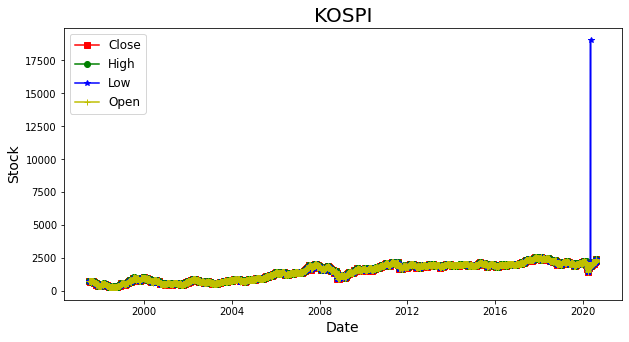

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (10,5)
#Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI', fontsize=20)
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

어라? 데이터가 뭔가 이상하다!

2020년 이후에 파란색 Low 가격에 이상한 값이 삐죽 솟아있는 부분이 눈에 뜁니다.

이렇게 비정상적으로 데이터 그래프가 솟아오른 부분을 스파이크(spike)라고 하고, 움푹 꺼진 부분을 딥(dip)이라고 합니다.

여러분, 당황 하지말고 침착히 상황을 분석해 봐요.

이상한 스파이크는 2020년 이후에 발생했고, Low Price 값이High 프라이스보다 훨씬 높게 삐죽 솟아 나와 있으니 확실히 이상한 데이터네요.

구체적인 수치를 확인하기 위해 pandas DataFrame에서 확인해 봅니다.

In [17]:
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume
5620,2020-05-06,1919.449951,1928.76001,19025.550781,1928.76001,1928.76001,1082200.0


범인은 2020년 5월 6일 이었네요. Low Price가 19025로 나타나 있어요.

이제 여러분은 시계열 데이터의 이상치 데이터가 무엇인지 감을 잡을수 있을 거에요.

이번에는 다행히 그래프를 통해 눈으로 여러분의 첫번째 이상치 데이터를 찾을 수 있었어요.

하지만, 이런 생각이 스쳐 갑니다.

###"이 이상치 데이터는 어떻게 처리하지?"

다음 단계에서는 이상치 데이터의 종류와 처리 방안을 알아봅니다.

#**4. Outlier/Novelties 구분하기**

우리가 갖고 있는 주식데이터에 관한 도메인 지식에 따르면, 

저가는 무조건 다른 가격들보다 낮은 가격이어야 해요. 

이런 규칙에 맞지 않았기 때문에 2020년 5월 6일의 이상한 데이터를 찾아 낼 수 있었어요.

이렇게 이상한 데이터, 즉 이상치(Anomalies)를 찾아내는 방법이 Anomaly Detection 입니다.

일반적으로는 이상치를 정상적인 데이터들의 분포에서 벗어난 데이터라고 정의하지만, 

세부방식에 따라 크게 Outlier와 Novelties 두 가지로 구분할 수 있습니다.

Outlier의 사전적 정의는 다음과 같습니다.

##통계적 자료 분석의 결과를 왜곡시키거나, 자료 분석의 적절성을 위협하는 변숫값 꼬는 사례.

Outlier는 일반적으로 단변량 분석의 결과로 찾아낼 수 있으며, 교정하지 않으면 자료 분석에 방해가 된다는 특징이 있습니다.

(대응 방안)특히, 비정상적인 데이터 수집 과정에 의한 극단치는 원본 데이터를 교정하여 없애는 걸 권장합니다.

- 참값으로 대체하거나
- 보간으로 대체하거나
- 삭제해야 합니다.


다행이 주식데이터는 네이버, 카카오 등 다양한 IT업체에서도 제공하는 데이터이다.

Supervised 방법을 통해서 데이터를 검증할 수 있어요.

카카오 주식차트로 확인해보면 Low는 1903이 맞는 값이네요.

반올림을 고려하면 야후에는 소수점 한 칸이 밀려서 입력된거 같습니다.

앞서서 발견된 이상치(2020년 5월 6일 Low값)은 비정상적인 수집 결과이므로 해당 데이터를 교정하여 없애봅시다.

In [18]:
#카카오 주식차트 결과로 대체합니다.
df.loc[df.Date == '2020-05-06', 'Low']= 1903

#비정상데이터가 제거되었는지 다시 확인해 봅니다.
df.loc[df.Low > df.High]

,Date,Open,High,Low,Close,Adj Close,Volume


**두 번째는, Novelties 특이치**

Novelties는 정상적인 수집과정에 의한 이상치를 의미합니다. 

이전까지는 보지 못한 패턴이나 데이터가 여기에 해당해요.

마치 블랙스완처럼요! 특이치는 우리가 모르는 도메인의 변화를 시사해요.

특이치는 일반적으로 다변량 분석의 결과로 탐색할 수 있어요.


**(대응방안)**

특이치는 극단치와 다르게 원본 데이터를 수정하지 안습니다.

나중에 특이치가 또 발생하면 모델이 대처해야 하거든요!

우리의 코스피 데이터에서는 코로나 사태로 인한 주식하락 같은 날벼락도 일종의 특이치 Novelties로 볼 수 있겠죠?

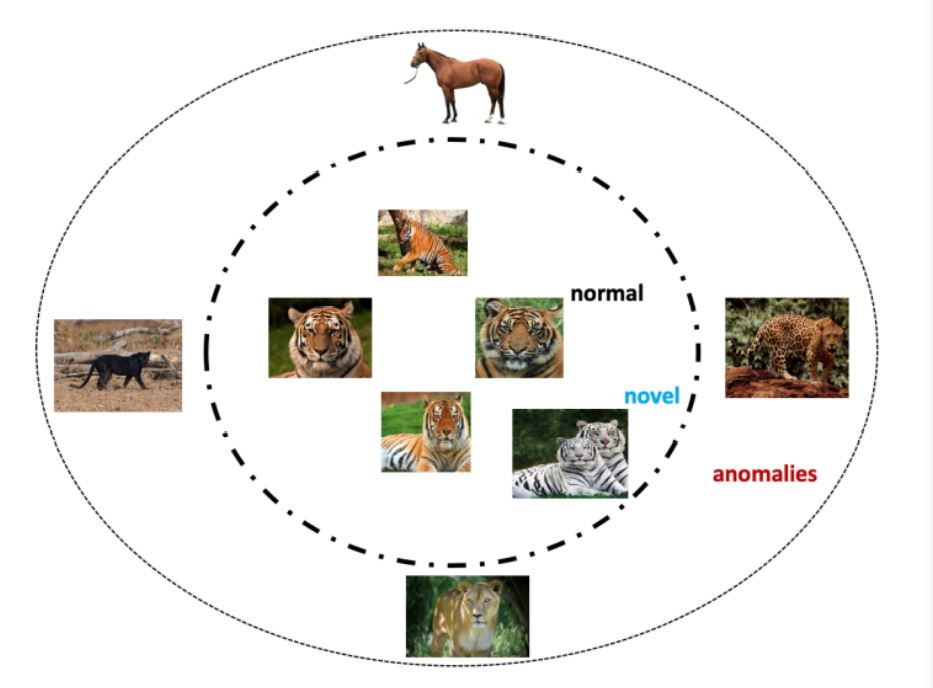

위 그림은 Novelty와 Anomalies의 개념적 차이를 설명하기 위해 제공된 것입니다.

정상적인 범주에서 벗어나는 이상 데이터라고 해도 엄밀히는 같은 것이 아니라는 것을 알 수 있을 겁니다.

위 그림을 예로 들자면, 만약 우리가 호랑이 라는 데이터를 조사한다고 했을때, 

하얀 호랑이 라는 것이 아무리 처음 관측되었다고 해도 그것이 호랑이의 범주에 든다면 그것은 특이치(Novelty)로 취급되어 호랑이 데이터 안에 포함되어야 합니다.

그러나 호랑이 데이터 안에 실수로 사자나 표범 같은 호랑이 범주 밖의 데이터가 끼어들었다면 그것은 극단치(Outlier)로 간주해서 호랑이 데이터에서 제외해야 하는거죠.

위 그림에서는 Normal의 범주 밖에 있는 것을 Outlier라고 하지 않고 Anomalies로 표기하고 있네요.

**Recap!!**

(세줄 요약)
- 이상치(Anomailies) = 극단치(Outlier) + 특이치(Novelites)
- 극단치는 제거해야 모형에 좋습니다.
- 특이치는 남겨둬야 모형에 좋습니다.

**모든 데이터에서 똑같은 방법으로 극단치와 특이치로 구분하나요?**

극단치와 특이치에는 사실 뉘앙스의 차이가 있을 뿐 명확한 구분 방법은 없습니다.

분석자의 주관이나 데이터의 도메인(분야)에 따라 조금씩 달라요.

결국 그 데이터 범주의 경계선을 어디에 그었느냐의 문제가 귀결될 것이기 때문에, 해당 도메인의 지식이 중요하게 취급됩니다.

우리가 다뤘던 주식 데이터에서도 만약 Open/Low/Close/High 등 데이터의 의미를 모르고 분석했다면 2020-05-06일 이상치를 찾아낼 수 있었을까요?


#**5. 전통적인 방법으로 이상데이터를 찾아보자!**

다른 출처에서 제공하는 데이터가 있다면 상호 비교하는 Supervised 방법으로 하나의 이상치를 제거할 수 있을 것입니다.

하지만, 야후 파이낸스와 달리 네이버/ 카카오는 코스피 데이터의 다운로드 기능을 제공하지 않습니다.

눈으로 하나하나 확인해볼 수도 없는 노릇! 

여러분은 숨어있을 다른 이상치들은 어떻게 처리하나 고민~고민하다가 예전 중고등학교 시절 배웠던 **정규분포**의 개념이 떠올랐어요.

어떤 데이터가 평균과 표준편차로 주어지는 정규분포를 따른다면 아주 높은 확률로 그 데이터는 어떤 **신뢰구간** 내에 있을거라고 가정할수 있으며.

그 신뢰구간 밖의 데이터가 나올 확률은 매우 희박해진다면 **신뢰구간 밖에 있는 데이터는 이상치** 라고 생각할 수 있지 않을까요?



In [19]:
pip install statsmodels


**기억 더듬어 보기: 신뢰구간**

중고등학교 시절 배웠던 '정규분포'와 '신뢰구간'의 개념을 잠깐 되짚어 볼까요?

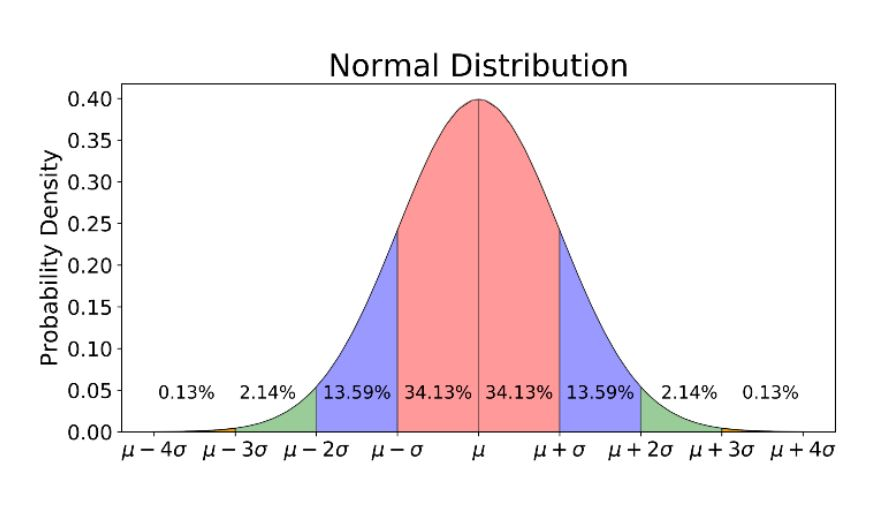

이번에 우리는 데이터가 '정규분포'를 따를때 사용 가능한 신뢰구간으로 이상치를 탐색할 거에요.

데이터가 정규분포를 따를 떄, 표준편차(o)의 배수로 신뢰구간의 상한과 하한을 결정해요. 

신뢰구간을 벗어나는 데이터는 일반적인 분포에서 벗어나는 '이상치'로 의심할 수 있어요.

- (2o를 기준으로 판단하면) 95.5%는 정상 데이터, 4.5%는 이상치
- (3o를 기준으로 판단하면) 99.7%는 정상데이터, 0.27%는 이상치로 분류할 수 있어요.

**(여기서 잠깐)

신뢰구간 분석을 통해 이상치를 찾아내는 방법은 데이터가 정규분포를 따를 때만 쓸 수 있는것은 아니랍니다.

데이터가 t-분포 등 특정 확률분포에 피팅이 된다면 그 확률분포의 신뢰구간 결정 방법을 적용할 수 있어요.

이상치를 찾아내는 통계적인 방법은 정말 다양하지만, 우리는 아래 두 가지 대표적인 방법을 알아보겠습니다.

- 정규분포르 따르는지 확인하는 방법:**z-test**
- 시계열 데이터중에서 정규분포에 가까운 데이터를 뽑아내는 방법: **Time series decomposition**